In [1]:
import os
import torch
import matplotlib.pyplot as plt

from bmadx.beam_generator import create_beam

from phase_space_reconstruction.virtual.beamlines import sextupole_drift
from phase_space_reconstruction.virtual.scans import run_sextupole_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.train import train_1d_scan_sext

from bmadx.plot import plot_projections
from phase_space_reconstruction.visualization import plot_scan_data, plot_predicted_screens

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
data_dir = 'data'

In [3]:
# create synthetic ground truth beam from base and transform yaml files
gt_beam = create_beam(base_yaml = os.path.join(data_dir,'base.yaml'),
                      transforms_yaml = os.path.join(data_dir,'transforms.yaml'), 
                      p0c = 10.0e6,
                      save_as = os.path.join('data', 'gt_beam.pt'))

ground truth distribution saved at data\gt_beam.pt


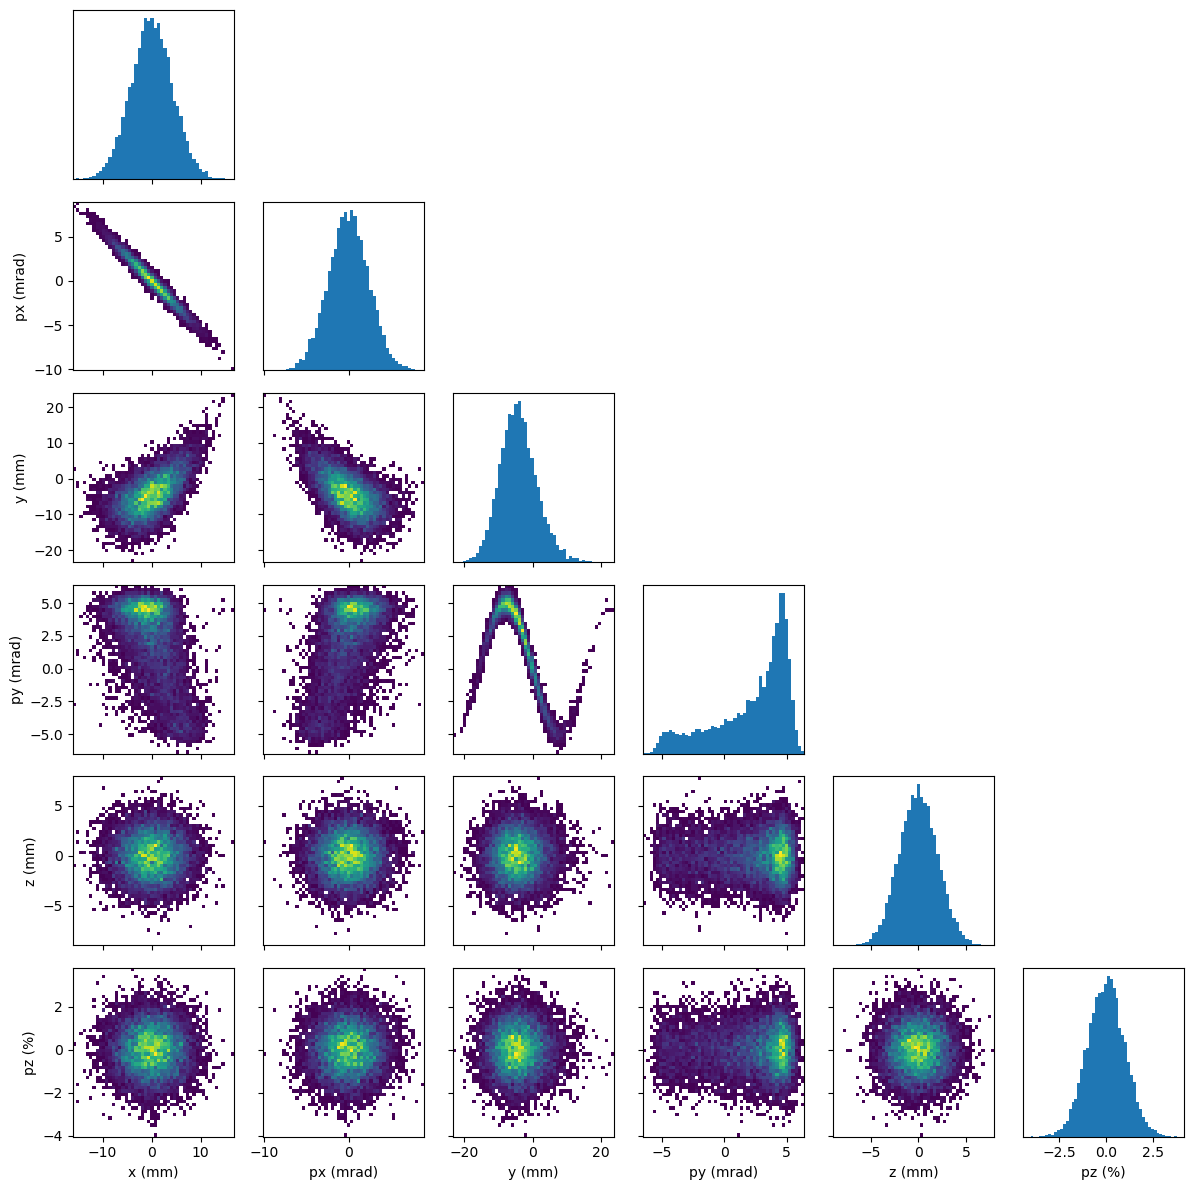

In [4]:
# plot synthetic ground truth beam projections 
fig, ax = plot_projections(gt_beam.numpy_particles())
plt.show()

In [5]:
# diagnostic beamline:
lattice = sextupole_drift()

# design momentum (eV)
p0c = 10.0e6

# quadrupole strengths for scan (reshape as: n_quad_strengths x n_images_per_quad_strength x 1)
n_ks = 20
ks = torch.linspace(-100, 100, n_ks).reshape((n_ks,1,1))*30

# split in training and testing sets
train_ks = ks[::2]
test_ks = ks[1::2]

# create diagnostic screen: 
bins = torch.linspace(-30, 30, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

In [6]:
# generate and save train and test datasets
train_dset = run_sextupole_scan(gt_beam, lattice, screen, train_ks, save_as=os.path.join('data',
                                                                        'train.dset'))
test_dset = run_sextupole_scan(gt_beam, lattice, screen, test_ks, save_as=os.path.join('data', 'test'
                                                                              '.dset'))

[('elements.0.L', Parameter containing:
tensor(0.1000)), ('elements.0.X_OFFSET', Parameter containing:
tensor(0.)), ('elements.0.Y_OFFSET', Parameter containing:
tensor(0.)), ('elements.0.NUM_STEPS', Parameter containing:
tensor(5)), ('elements.0.TILT', Parameter containing:
tensor(0.)), ('elements.0.K2', Parameter containing:
tensor([[[-3000.0000]],

        [[-2368.4211]],

        [[-1736.8422]],

        [[-1105.2632]],

        [[ -473.6842]],

        [[  157.8948]],

        [[  789.4736]],

        [[ 1421.0527]],

        [[ 2052.6316]],

        [[ 2684.2107]]])), ('elements.1.L', Parameter containing:
tensor(1.))]
dataset saved as 'data\train.dset'
[('elements.0.L', Parameter containing:
tensor(0.1000)), ('elements.0.X_OFFSET', Parameter containing:
tensor(0.)), ('elements.0.Y_OFFSET', Parameter containing:
tensor(0.)), ('elements.0.NUM_STEPS', Parameter containing:
tensor(5)), ('elements.0.TILT', Parameter containing:
tensor(0.)), ('elements.0.K2', Parameter containing:
ten

image size = 60 x 60 mm
test samples boxed in orange


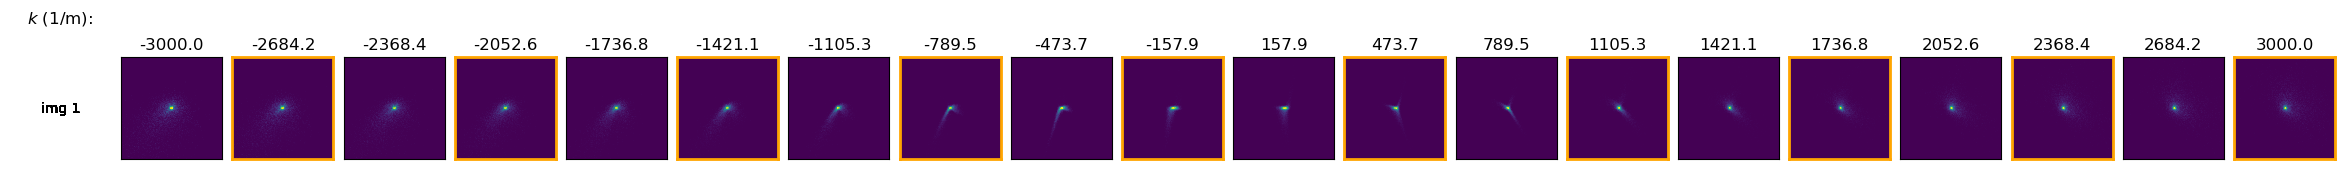

In [7]:
# plot generated datasets
fig, ax = plot_scan_data(train_dset, test_dset, bins, bins)
fig.set_size_inches(30,2)
plt.show()

In [8]:
# training
pred_beam = train_1d_scan_sext(train_dset, lattice, p0c, screen, n_epochs=1000,
                            device='cuda')

Using device: cuda


C:\Users\Ryan Roussel\mambaforge\envs\phase_space_reconstruction\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0 tensor(4726046., device='cuda:0', grad_fn=<MulBackward0>)
100 tensor(1006121.5000, device='cuda:0', grad_fn=<MulBackward0>)
200 tensor(991818.8750, device='cuda:0', grad_fn=<MulBackward0>)
300 tensor(986319.3750, device='cuda:0', grad_fn=<MulBackward0>)
400 tensor(935944.0625, device='cuda:0', grad_fn=<MulBackward0>)
500 tensor(956789.4375, device='cuda:0', grad_fn=<MulBackward0>)
600 tensor(948349.6250, device='cuda:0', grad_fn=<MulBackward0>)
700 tensor(949217.6250, device='cuda:0', grad_fn=<MulBackward0>)
800 tensor(924620.9375, device='cuda:0', grad_fn=<MulBackward0>)
900 tensor(897909.0625, device='cuda:0', grad_fn=<MulBackward0>)


In [9]:
# predicted screens:
pred_dset = run_sextupole_scan(pred_beam, lattice, screen, ks)

[('elements.0.L', Parameter containing:
tensor(0.1000)), ('elements.0.X_OFFSET', Parameter containing:
tensor(0.)), ('elements.0.Y_OFFSET', Parameter containing:
tensor(0.)), ('elements.0.NUM_STEPS', Parameter containing:
tensor(5)), ('elements.0.TILT', Parameter containing:
tensor(0.)), ('elements.0.K2', Parameter containing:
tensor([[[-3000.0000]],

        [[-2684.2107]],

        [[-2368.4211]],

        [[-2052.6316]],

        [[-1736.8422]],

        [[-1421.0527]],

        [[-1105.2632]],

        [[ -789.4736]],

        [[ -473.6842]],

        [[ -157.8948]],

        [[  157.8948]],

        [[  473.6842]],

        [[  789.4736]],

        [[ 1105.2632]],

        [[ 1421.0527]],

        [[ 1736.8422]],

        [[ 2052.6316]],

        [[ 2368.4211]],

        [[ 2684.2107]],

        [[ 3000.0000]]])), ('elements.1.L', Parameter containing:
tensor(1.))]


image size = 60 x 60 mm
test samples boxed in orange


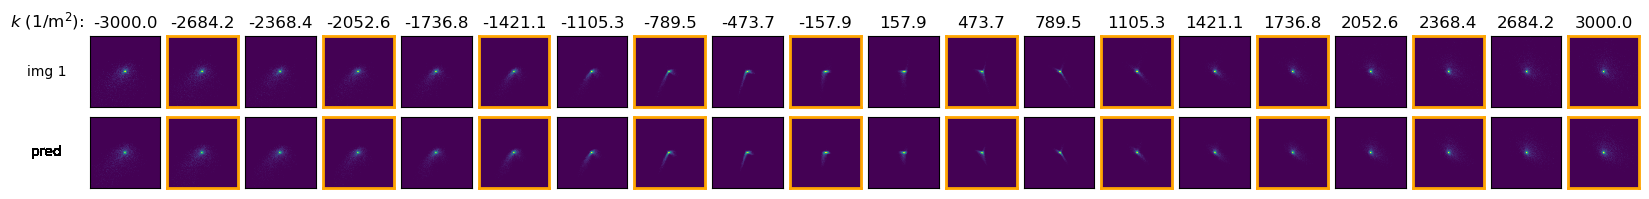

In [10]:
# compare predicted screens with data
fig, ax = plot_predicted_screens(pred_dset, train_dset, test_dset, bins, bins)
plt.show()

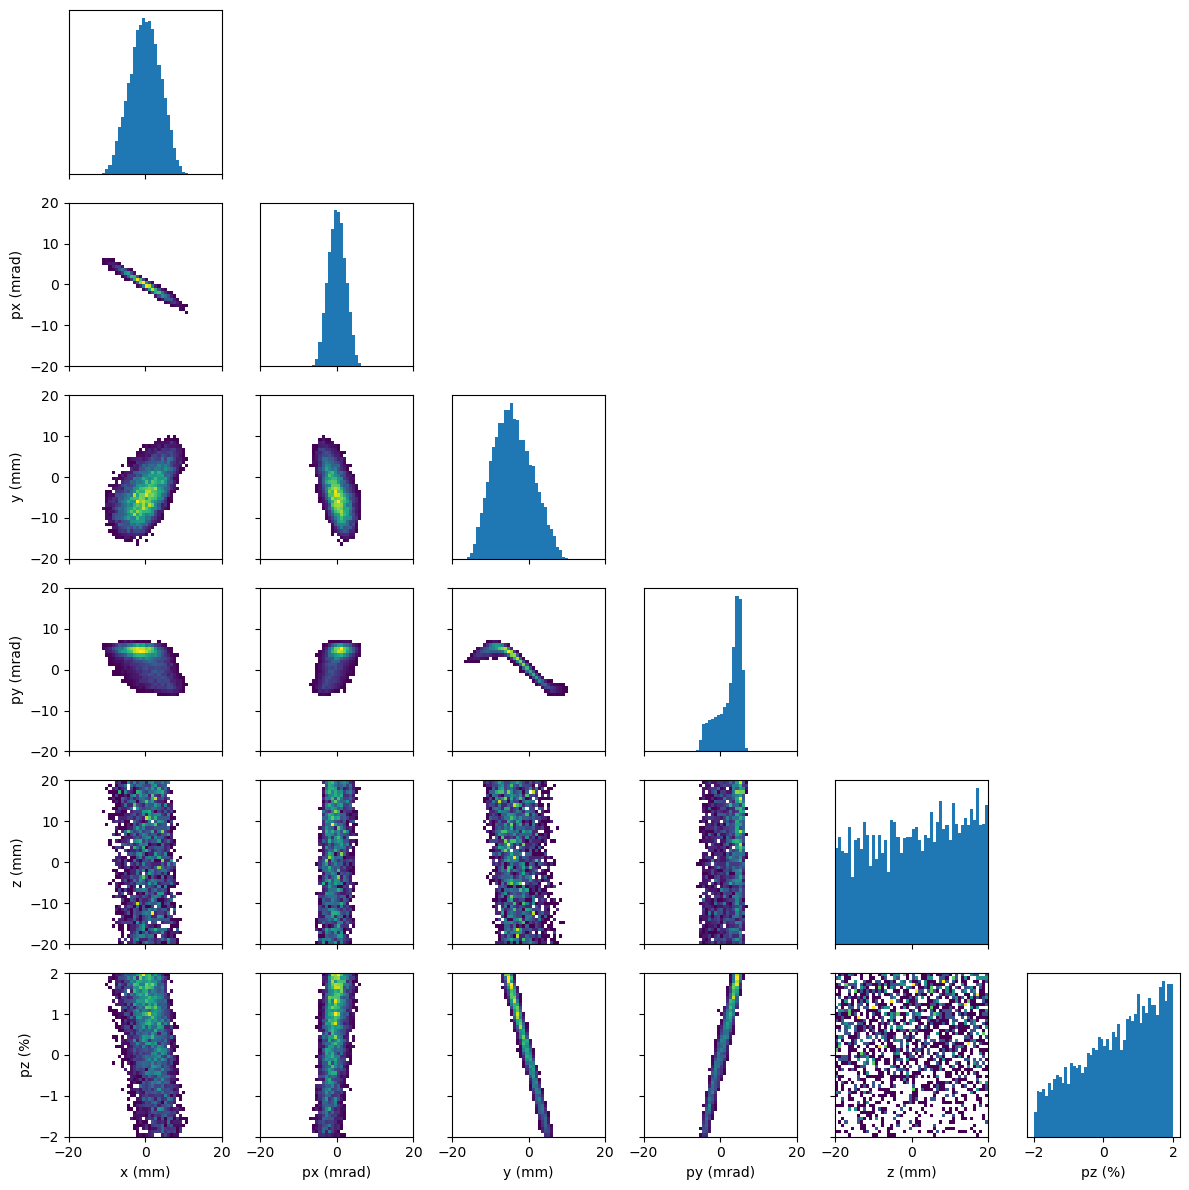

In [14]:
# reconstructed beam projections: 
fig, ax = plot_projections(pred_beam.numpy_particles(),
                           coords=('x', 'px', 'y', 'py',"z","pz"),
                           same_lims=True,
                           custom_lims=[-20e-3,20e-3]
                           )
plt.show()

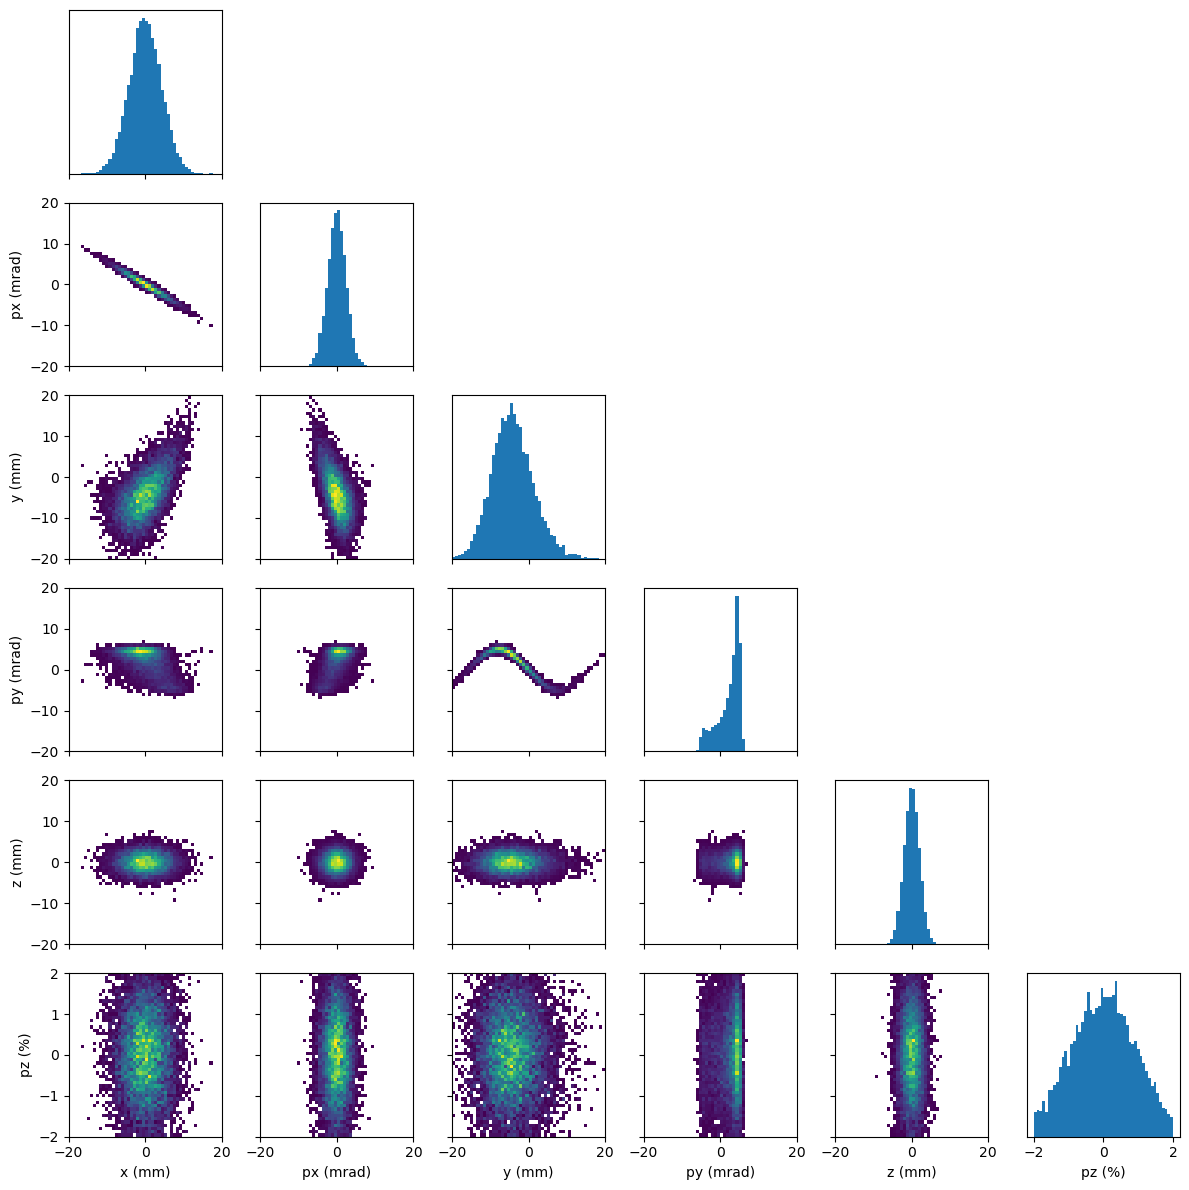

In [15]:
# ground truth beam projections:
fig, ax = plot_projections(gt_beam.numpy_particles(),
                           coords=('x', 'px', 'y', 'py',"z","pz"),
                           same_lims=True,
                           custom_lims = [-20e-3, 20e-3]
                           )
plt.show()

In [13]:
torch.cuda.empty_cache()